Importing packages

In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix, f1_score, classification_report
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import re
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.layers import Embedding, LSTM, Dense, SpatialDropout1D, Bidirectional, Conv1D, MaxPooling1D
from keras.models import Sequential
from keras.callbacks import EarlyStopping
import pickle
from google.colab import drive
from keras.regularizers import L1L2
from keras import backend as K

Mounting google drive into colab notebook

In [2]:
drive.mount('/content/drive')

Mounted at /content/drive


Declaring global constant values

In [24]:
# Maximum number of words that the embedding will have
MAX_NUM_WORDS = 50000
# Size of dimension that embedding layer will use
EMBEDDING_DIM = 100
# Maximum number of words that each tweet will have
MAX_SEQUENCE_LENGTH = 100

Defining utility functions for tokenizer

In [4]:
def create_tokenizer(input_data, save_path):
  tokenizer = Tokenizer(num_words=MAX_NUM_WORDS,
    filters='!"#$%&()*+,-./:;<=>?@[\]^_`{|}~',
    lower=True)
  tokenizer.fit_on_texts(input_data)
  save_tokenizer(tokenizer, save_path)
  return tokenizer

# Saves tokenizer in file system with a given name
def save_tokenizer(tokenizer, filename):
  with open(filename, 'wb') as f:
    pickle.dump(tokenizer, f,
    protocol=pickle.HIGHEST_PROTOCOL)

# Loads tokenizer object from filesystem by filename
def load_tokenizer(filename):
  with open(filename, 'rb') as f:
    tokenizer = pickle.load(f)
    return tokenizer


Defining a function for plotting graphs of loss and f1 scores of training history

In [5]:
def plot_model(history):
  # Plotting train and validation loss graph
  plt.title('Loss')
  plt.plot(history.history['loss'], label='train')
  plt.plot(history.history['val_loss'],
    label='test')
  plt.legend()
  plt.show()

  # Plotting train and validation accuracy graph
  plt.title('Accuracy')
  plt.plot(history.history['accuracy'], label='train')
  plt.plot(history.history['val_accuracy'],
    label='test')
  plt.legend()
  plt.show()

  # Plotting train and validation F1 score graph
  plt.title('F1 score')
  plt.plot(history.history['f1_m'], label='train')
  plt.plot(history.history['val_f1_m'],
    label='test')
  plt.legend()
  plt.show()

Defining a function for evaluating a model with data and labels

In [6]:
def evaluate(model, X_test, Y_test):
  # Generating predicted model outcomes of given data
  Y_pred = model.predict(X_test)
  # Rounding outputs to binary numbers
  Y_pred = np.round().astype('int').flatten()
  # Prints classification report for predictions compared to ground truths
  print(classification_report(Y_test, Y_pred))

Defining a function for transforming an array of texts into embeddings

In [7]:
def transform_text(tokenizer, texts):
  # Transform texts into embedding vectors with a given tokenizer
  sequences = tokenizer.texts_to_sequences(texts)
  # Left padding each vector with zeros to match lengths of all vectors
  return pad_sequences(sequences, maxlen=MAX_SEQUENCE_LENGTH)

Loading datasets

In [8]:
df_train = pd.read_csv("/content/drive/MyDrive/Works/NLP/Project_1/train.csv")
df_test = pd.read_csv("/content/drive/MyDrive/Works/NLP/Project_1/test.csv")

Describing the dataset

In [9]:
df_train.head(10)

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1
5,8,NaN,NaN,#RockyFire Update => California Hwy. 20 closed...,1
6,10,NaN,NaN,#flood #disaster Heavy rain causes flash flood...,1
7,13,NaN,NaN,I'm on top of the hill and I can see a fire in...,1
8,14,NaN,NaN,There's an emergency evacuation happening now ...,1
9,15,NaN,NaN,I'm afraid that the tornado is coming to our a...,1


In [10]:
df_train.describe()

,id,target
count,7613.000000,7613.00000
mean,5441.934848,0.42966
std,3137.116090,0.49506
min,1.000000,0.00000
25%,2734.000000,0.00000
50%,5408.000000,0.00000
75%,8146.000000,1.00000
max,10873.000000,1.00000


In [11]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7613 entries, 0 to 7612
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   id        7613 non-null   int64 
 1   keyword   7552 non-null   object
 2   location  5080 non-null   object
 3   text      7613 non-null   object
 4   target    7613 non-null   int64 
dtypes: int64(2), object(3)
memory usage: 297.5+ KB


In [12]:
# Length of longest text based on number of words
len(max(df_train['text'].apply(lambda x: x.split()), key=len))

31

<Axes: >

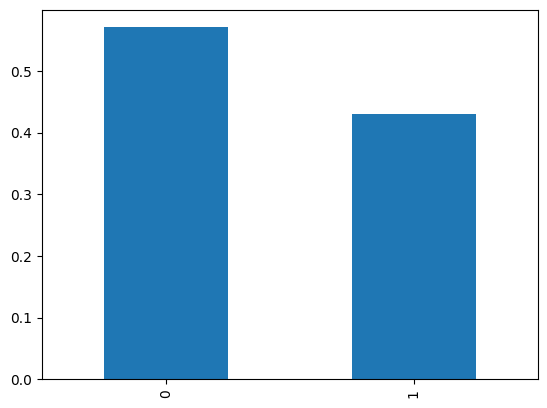

In [19]:
# Describing distribution of target values
df_train['target'].value_counts(normalize=True).plot.bar()

In [13]:
df_test.head(10)

,id,keyword,location,text
0,0,NaN,NaN,Just happened a terrible car crash
1,2,NaN,NaN,"Heard about #earthquake is different cities, s..."
2,3,NaN,NaN,"there is a forest fire at spot pond, geese are..."
3,9,NaN,NaN,Apocalypse lighting. #Spokane #wildfires
4,11,NaN,NaN,Typhoon Soudelor kills 28 in China and Taiwan
5,12,NaN,NaN,We're shaking...It's an earthquake
6,21,NaN,NaN,They'd probably still show more life than Arse...
7,22,NaN,NaN,Hey! How are you?
8,27,NaN,NaN,What a nice hat?
9,29,NaN,NaN,Fuck off!


Defining function for data sample(Text) level preprocessing

In [14]:
# Downloading nltk packages
nltk.download(['stopwords', 'wordnet'])
sw = stopwords.words('english')
lemmatizer = WordNetLemmatizer()

# Function for cleaning a text
def clean_text(text):
    # Changing text into its lowercase form
    text = text.lower()

    # Replacing everything with space except (a-z, A-Z, ".", "?", "!", ",")
    text = re.sub(r"[^a-zA-Z?.!,¿]+", " ", text)

    # Removing URLs
    text = re.sub(r"http\S+", "",text)

    # Removing html tags
    html=re.compile(r'<.*?>')
    text = html.sub(r'',text)

    # Removing punctuations
    punctuations = '@#!?+&*[]-%.:/();$=><|{}^' + "'`" + '_'
    for p in punctuations:
        text = text.replace(p,'')

    # Removing stopwords
    text = [word for word in text.split() if word not in sw]
    # text = [lemmatizer.lemmatize(word) for word in text]
    text = " ".join(text)

    # Removing emojis
    emoji_pattern = re.compile("["
                           u"\U0001F600-\U0001F64F"  # emoticons
                           u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                           u"\U0001F680-\U0001F6FF"  # transport & map symbols
                           u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                           u"\U00002702-\U000027B0"
                           u"\U000024C2-\U0001F251"
                           "]+", flags=re.UNICODE)
    text = emoji_pattern.sub(r'', text)

    return text

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...


Defining a function for dataframe level preprocessing

In [15]:
def preprocess(df):
  # Clean each text in the dataframe
  df['text'] = df['text'].apply(lambda x: clean_text(x))
  # Filling null values with 'No information' text
  df = df.fillna('No information', axis=1)
  # Appending other features into text field
  df['text'] = 'KEYWORD ' + df.keyword + ' LOCATION ' + df.location + ' TEXT ' + df.text
  # Removing columns for already appended features
  df.drop(["id", "keyword", "location"], inplace=True, axis=1)
  return df

Preprocessing the datasets

In [16]:
df_train = preprocess(df_train)
df_test = preprocess(df_test)

Preparing data for training

In [20]:
# Create tokenizer
tokenizer = create_tokenizer(df_train['text'].values, 'disaster_tokenizer.pickle')
# Obtain embeddings for training data
X = transform_text(tokenizer, df_train['text'].values)
# Getting training labels
Y = df_train['target'].values.astype('int')
# Splitting the training dataset into train and validation
X_train, X_val, Y_train, Y_val = train_test_split(X,Y, test_size = 0.20, random_state = 42)

Defining metric functions

In [21]:
def recall_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall

def precision_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision

def f1_m(y_true, y_pred):
    precision = precision_m(y_true, y_pred)
    recall = recall_m(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))

Building the LSTM model

In [25]:
model = Sequential()
# Adam optimizer with learning rate of 0.00005
optimizer = tf.keras.optimizers.Adam(5e-5)
# Embedding layer
model.add(Embedding(MAX_NUM_WORDS, EMBEDDING_DIM,
  input_length=MAX_SEQUENCE_LENGTH))
# Dropout
model.add(SpatialDropout1D(0.2))
# Convolutional layer with kernel size 5
model.add(Conv1D(filters=64, kernel_size=5, padding='same', activation='relu'))
# Max pooling layer to reduce neuron size
model.add(MaxPooling1D(pool_size=3))
# Bidirectional LSTM with 64 units with dropout and regularization
model.add(Bidirectional(LSTM(64, dropout=0.2, recurrent_dropout=0.2,
               kernel_regularizer= L1L2(l1=0.01, l2=0.0))))
# Binary output layer with sigmoid function
model.add(Dense(1, activation='sigmoid'))

In [26]:
# Defining loss for binary classification
loss='binary_crossentropy'
model.compile(loss=loss, optimizer=optimizer, metrics=['accuracy', f1_m, precision_m, recall_m])
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 100, 100)          5000000   
                                                                 
 spatial_dropout1d_1 (Spati  (None, 100, 100)          0         
 alDropout1D)                                                    
                                                                 
 conv1d_1 (Conv1D)           (None, 100, 64)           32064     
                                                                 
 max_pooling1d_1 (MaxPoolin  (None, 33, 64)            0         
 g1D)                                                            
                                                                 
 bidirectional_1 (Bidirecti  (None, 128)               66048     
 onal)                                                           
                                                      

In [27]:
X_train

array([[    0,     0,     0, ...,  7114,     4, 18761],
       [    0,     0,     0, ...,   231,    91, 14889],
       [    0,     0,     0, ...,    25,    42, 18557],
       ...,
       [    0,     0,     0, ...,  9478,    33,    38],
       [    0,     0,     0, ...,     4, 24127, 24128],
       [    0,     0,     0, ...,     4, 23467,    48]], dtype=int32)

In [28]:
Y_train

array([1, 0, 1, ..., 0, 1, 1])

Training the model

In [29]:
epochs = 20
batch_size = 32
# Callback for stopping training when validation loss converges or drops during training
es = EarlyStopping(monitor='val_loss', patience=3, min_delta=1e-5)
# Training on train data and getting training history object
history = model.fit(X_train, Y_train, epochs=epochs, batch_size=batch_size,
                    validation_split=0.2, callbacks=[es], shuffle=True)
# Saving model in file system
model.save('/content/drive/MyDrive/Works/NLP/Project_1/disaster_model_4.keras')

Epoch 1/20
153/153 [==============================] - 47s 198ms/step - loss: 21.8758 - accuracy: 0.5704 - f1_m: 0.0074 - precision_m: 0.0196 - recall_m: 0.0050 - val_loss: 20.6542 - val_accuracy: 0.5616 - val_f1_m: 0.0000e+00 - val_precision_m: 0.0000e+00 - val_recall_m: 0.0000e+00
Epoch 2/20
153/153 [==============================] - 29s 190ms/step - loss: 19.5042 - accuracy: 0.5714 - f1_m: 0.0000e+00 - precision_m: 0.0000e+00 - recall_m: 0.0000e+00 - val_loss: 18.3559 - val_accuracy: 0.5616 - val_f1_m: 0.0000e+00 - val_precision_m: 0.0000e+00 - val_recall_m: 0.0000e+00
Epoch 3/20
153/153 [==============================] - 28s 184ms/step - loss: 17.2740 - accuracy: 0.5714 - f1_m: 0.0000e+00 - precision_m: 0.0000e+00 - recall_m: 0.0000e+00 - val_loss: 16.1973 - val_accuracy: 0.5616 - val_f1_m: 0.0000e+00 - val_precision_m: 0.0000e+00 - val_recall_m: 0.0000e+00
Epoch 4/20
153/153 [==============================] - 28s 184ms/step - loss: 15.1837 - accuracy: 0.5714 - f1_m: 0.0000e+00 - pr

Evaluating model outputs and training

In [30]:
# Evaluating the model on validation dataset
loss, accuracy, f1_score,_,_ = model.evaluate(X_val, Y_val, verbose=0)
print("F1 score: ", f1_score)

F1 score:  0.7385985255241394


48/48 [==============================] - 3s 36ms/step
              precision    recall  f1-score   support

           0       0.80      0.84      0.82       874
           1       0.77      0.72      0.74       649

    accuracy                           0.79      1523
   macro avg       0.78      0.78      0.78      1523
weighted avg       0.79      0.79      0.78      1523



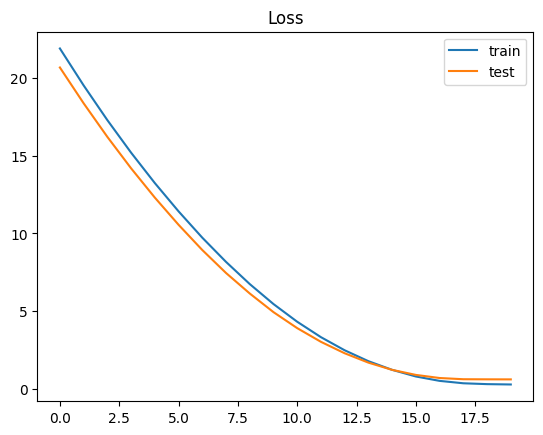

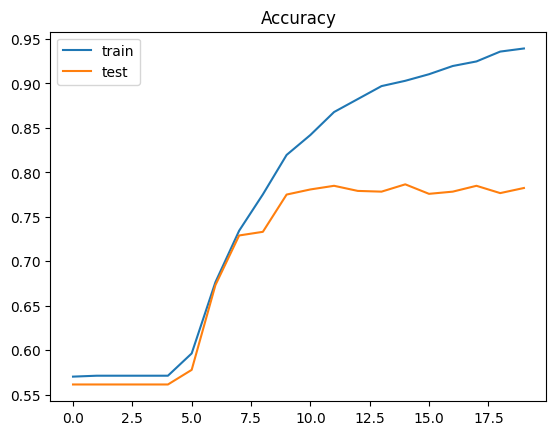

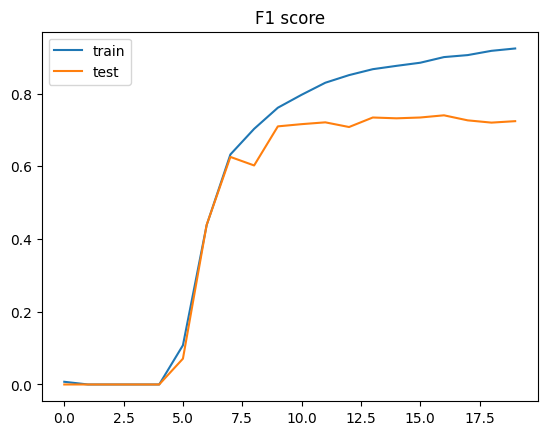

In [31]:
Y_pred = model.predict(X_val)
Y_pred = Y_pred.round().astype('int').flatten()
print(classification_report(Y_val, Y_pred))
plot_model(history)

Testing the model on example texts

In [36]:
example_texts = ['I got a tornado notification just now, take care everyone!!!',
                 'A truck containing 15 tonns of gas exploded in the middle of the city, costing lives of 3 firefighters',
                 'It has been raining heavily for the last 5 days',
                 'A 7.6 magnitude earthquake struck Japan on Jan. 1 around 2:10 a.m. EST (0710 GMT, or 4:10 p.m. local time in Japan)',
                 'Have a great weekends']
example_texts = [clean_text(x) for x in example_texts]
example_texts_emb = transform_text(tokenizer, example_texts)

example_predictions = model.predict(example_texts_emb)
print(np.column_stack((np.array(example_texts), np.array(example_predictions))))

1/1 [==============================] - 0s 47ms/step
[['got tornado notification now, take care everyone' '0.04601644']
 ['truck containing tonns gas exploded middle city, costing lives firefighters'
  '0.113581106']
 ['raining heavily last days' '0.034441765']
 ['magnitude earthquake struck japan jan around est gmt, pm local time japan'
  '0.8195585']
 ['great weekends' '0.034434654']]


Testing the model on test dataframe

In [37]:
# Get embeddings for test dataframe
X_test = df_test['text']
X_test_cv = transform_text(tokenizer, X_test)

# Generate predictions
predictions = model.predict(X_test_cv)
predictions = predictions.round().astype('int').flatten()
predictions

102/102 [==============================] - 2s 16ms/step


array([0, 1, 1, ..., 1, 1, 0])

In [38]:
predicted_df = df_test.copy()
predicted_df['target'] = predictions

In [39]:
predicted_df

,text,target
0,KEYWORD No information LOCATION No information...,0
1,KEYWORD No information LOCATION No information...,1
2,KEYWORD No information LOCATION No information...,1
3,KEYWORD No information LOCATION No information...,0
4,KEYWORD No information LOCATION No information...,0
...,...,...
3258,KEYWORD No information LOCATION No information...,0
3259,KEYWORD No information LOCATION No information...,1
3260,KEYWORD No information LOCATION No information...,1
3261,KEYWORD No information LOCATION No information...,1


In [40]:
submission_df = pd.read_csv(f'/content/drive/MyDrive/Works/NLP/Project_1/sample_submission.csv')
submission = pd.DataFrame({"id": submission_df['id'],
            "target":predictions})
submission.to_csv('/content/submission.csv', index=False)